# Time Series Analysis dan Forecasting menggunakan SARIMAX

Notebook ini merupakan bagian dari buku **Fundamental Machine Learning menggunakan Python** oleh **Fahmi Noor Fiqri**. Notebook ini berisi contoh kode untuk **Bab 10 - SARIMAX.**

In [21]:
# Mengimpor library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import rmse

In [22]:
# Fungsi untuk uji stasioner dan dekomposisi komponen time series
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print('>> Dickey-Fuller Test <<')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value

    print(dfoutput)

## Data Ingestion

In [23]:
# Membaca data dari file CSV
df = pd.read_csv(r'../datasets/air-passengers.csv', parse_dates=True, index_col="month")

## Exploratory Data Analysis dan Preprocessing

In [24]:
# Menampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


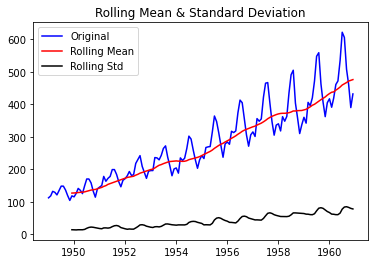

>> Dickey-Fuller Test <<
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [25]:
# Uji stasioner data mentah
test_stationarity(df)

## Preprocessing

In [26]:
# Transformasi logaritmik
df_log = df.copy()
df_log["passengers"] = df_log["passengers"].apply(np.log)

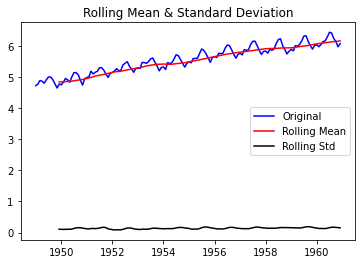

>> Dickey-Fuller Test <<
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [27]:
# Uji stasioner
test_stationarity(df_log)

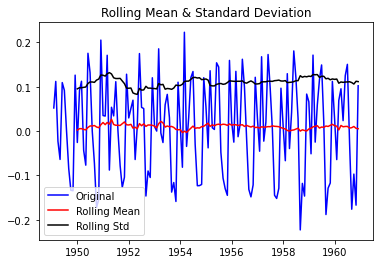

>> Dickey-Fuller Test <<
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [28]:
# Uji stasioner pada data dengan lag = 1
df_log_diff = df_log - df_log.shift()
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

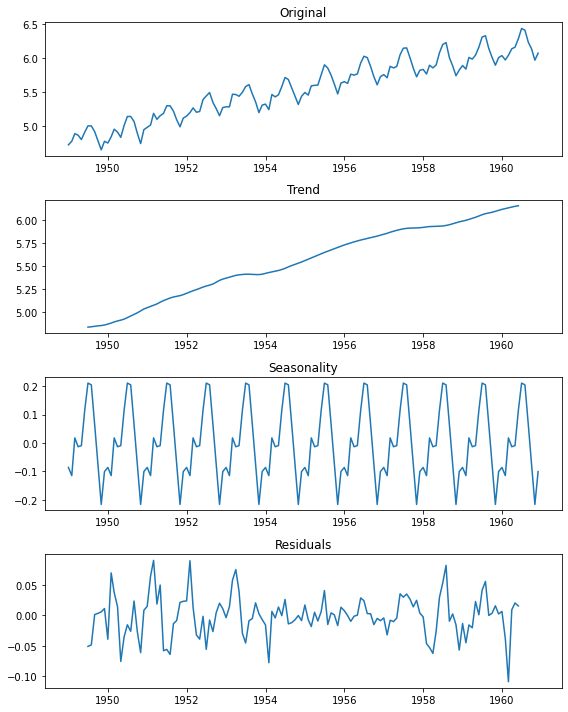

In [29]:
# Dekomposisi komponen musiman
decomposition = seasonal_decompose(df_log)

plt.figure(figsize=(8,10))
ax1 = plt.subplot(4, 1, 1)
plt.plot(df_log)
ax1.set_title("Original")
ax1.set_xticklabels([])

ax2 = plt.subplot(4, 1, 2, sharex=ax1)
plt.plot(decomposition.trend)
ax2.set_title("Trend")
ax2.set_xticklabels([])

ax3 = plt.subplot(4, 1, 3, sharex=ax1)
plt.plot(decomposition.seasonal)
ax3.set_title("Seasonality")
ax3.set_xticklabels([])

ax4 = plt.subplot(4, 1, 4, sharex=ax1)
plt.plot(decomposition.resid)
ax4.set_title("Residuals")

plt.tight_layout()

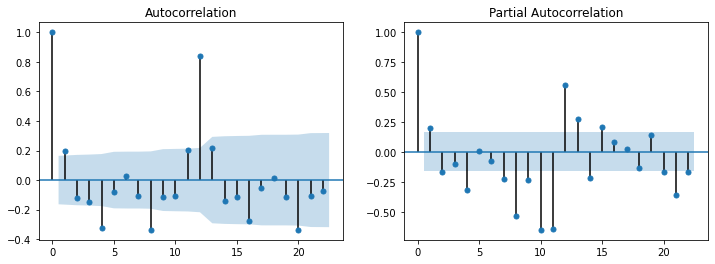

In [30]:
# Plot ACF dan PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_log_diff, ax=ax1)
plot_pacf(df_log_diff, ax=ax2)

fig.show()

## Training

In [31]:
# Cari parameter yang terbaik
auto_arima(df_log["passengers"], m=12, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-489.188, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-358.005, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-472.836, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-423.080, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-152.756, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-457.177, Time=0.35 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-487.374, Time=1.47 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-487.408, Time=4.18 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-482.644, Time=1.33 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-486.388, Time=4.93 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-482.026, Time=1.04 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-486.778, Time=0.99 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-487.052, Time=1.40 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-367.061, Time=0.36 sec
 ARIMA(0,0,2)(0,1,1

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

In [32]:
# Membuat model SARIMAX dengan model (2,0,0)x(0,1,1,12)
model = SARIMAX(df_log, trend='c', order=(2, 0, 0), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

D:\app-store\bin\miniconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\app-store\bin\miniconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [33]:
# Deskripsi model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           passengers   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 249.648
Date:                              Sun, 23 Aug 2020   AIC                           -489.295
Time:                                      07:16:20   BIC                           -474.881
Sample:                                  01-01-1949   HQIC                          -483.438
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0193      0.008      2.330      0.020       0.003       0.035
ar.L1          0.5756      0.075      7.646      0.000       0.428       0.723
ar.L2          0.2618      0.084      3.124      0.002       0.098       0.426
ma.S.L12      -0.5544      0.106     -5.219      0.000      -0.763      -0.346
sigma2         0.0013      0.000      8.856      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       42.46   Jarque-Bera (JB):                 6.45
Prob(Q):                              0.37   Prob(JB):                         0.04
Heteroskedasticity (H):               0.57   Skew:                             0.07
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluation

In [34]:
# Melakukan prediksi data 36 bulan terakhir
y_base = pd.Series(df_log["passengers"][-36:]).apply(np.exp)
y_pred = model_fit.predict(start=df_log.index[-36], end=df_log.index[-1]).apply(np.exp)

print("MSE: {}".format(mse(y_base, y_pred)))
print("RMSE: {}".format(rmse(y_base, y_pred)))

MSE: 223.5818434881702
RMSE: 14.952653392898874


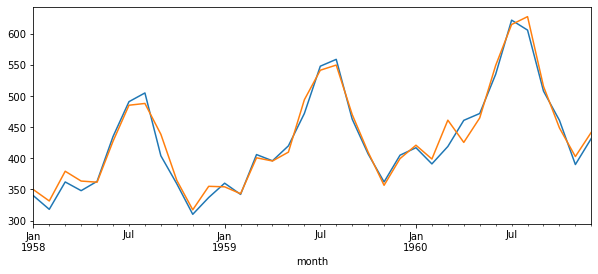

In [35]:
# Plot hasil prediksi pada interval 36 hari terakhir
fig, ax = plt.subplots(figsize=(10,4))
y_base.plot(ax=ax)
y_pred.plot(ax=ax)

## Prediction

In [36]:
# Lakukan forecast 30 bulan ke depan
forecasted = model_fit.get_forecast(30)

y = df_log["passengers"].apply(np.exp)
y_forecast = pd.Series(forecasted.predicted_mean).apply(np.exp)
y_interval = forecasted.conf_int().apply(np.exp)

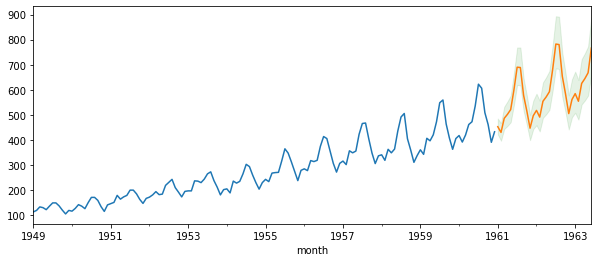

In [37]:
# Plot hasil forecast
fig, ax = plt.subplots(figsize=(10,4))
y.plot(ax=ax)
y_forecast.plot(ax=ax)
ax.fill_between(y_interval.index, y_interval.iloc[:,0], y_interval.iloc[:,1], color='g', alpha=0.1)